# YOLOv8 Training for Car Engine Bay Detection

This notebook walks through the complete process of setting up, training, and exporting a YOLOv8 model to detect components in car engine bays. The final model will be exported to ONNX format, suitable for deployment on devices like the Meta Quest 3.

## 1. Environment Setup

First, we install the necessary Python packages. `ultralytics` is the core package for YOLOv8, and `kaggle` is used to download the dataset.

In [ ]:
#%pip install ultralytics kaggle pandas Pillow scikit-learn matplotlib

## 2. Prepare Dataset for YOLOv8

The dataset is already available. This step will prepare it for training by:
1.  Defining the class names.
2.  Splitting the data into training and validation sets.
3.  Creating the `dataset.yaml` file.

In [ ]:
import os
import yaml
import shutil
from pathlib import Path
from sklearn.model_selection import train_test_split

print("--- Starting Dataset Preparation ---")

# --- 1. Define Paths and Class Names ---
DATASET_PATH = Path("dataset")
IMAGES_PATH = DATASET_PATH / "images"
LABELS_PATH = DATASET_PATH / "labels" / "labels"
YOLO_DATA_PATH = DATASET_PATH / "yolo_data"
YOLO_IMAGES_PATH = YOLO_DATA_PATH / "images"
YOLO_LABELS_PATH = YOLO_DATA_PATH / "labels"

class_list = [
    'Inverter Coolant Reservoir', 'Battery', 'Radiator Cap', 'Windshield Wiper Fluid', 
    'Fuse Box', 'Power Steering Reservoir', 'Brake Fluid', 'Engine Oil Fill Cap', 
    'Engine Oil Dip Stick', 'Air Filter Cover', 'ABS Unit', 'Alternator', 
    'Engine Coolant Reservoir', 'Radiator', 'Air Filter', 'Engine Cover', 
    'Cold Air Intake', 'Clutch Fluid Reservoir', 'Transmission Oil Dip Stick', 
    'Intercooler Coolant Reservoir', 'Oil Filter Housing', 'ATF Oil Reservoir', 
    'Cabin Air Filter Housing', 'Secondary Coolant Reservoir', 'Electric Motor', 'Oil Filter'
]

print(f"Found {len(class_list)} classes.")

# --- 2. Create YOLO directory only if missing ---
if not YOLO_DATA_PATH.exists():
    print("Creating YOLO dataset folder...")
    YOLO_IMAGES_PATH.mkdir(parents=True)
    YOLO_LABELS_PATH.mkdir(parents=True)
else:
    print("YOLO dataset already exists. Skipping rebuild.")
    print("If you want to force rebuild, delete 'dataset/yolo_data' manually.")
    # raise SystemExit()   # <-- STOP SCRIPT HERE

# --- 3. Collect ONLY valid image-label pairs ---
image_files = sorted([f for f in IMAGES_PATH.glob("*.jpg")])
valid_pairs = []
missing_labels = []

for img in image_files:
    lbl = LABELS_PATH / f"{img.stem}.txt"
    if lbl.exists():
        valid_pairs.append((img, lbl))
    else:
        missing_labels.append(img)

print(f"Valid image-label pairs: {len(valid_pairs)}")
print(f"Missing labels: {len(missing_labels)}")

# --- 4. Split dataset ---
imgs = [x[0] for x in valid_pairs]
lbls = [x[1] for x in valid_pairs]

train_imgs, val_imgs, train_lbls, val_lbls = train_test_split(
    imgs, lbls, test_size=0.2, random_state=42
)

def copy_split(images, labels, split):
    img_dir = YOLO_IMAGES_PATH / split
    lbl_dir = YOLO_LABELS_PATH / split
    img_dir.mkdir(parents=True, exist_ok=True)
    lbl_dir.mkdir(parents=True, exist_ok=True)

    for img, lbl in zip(images, labels):
        shutil.copy(img, img_dir / img.name)
        shutil.copy(lbl, lbl_dir / lbl.name)

copy_split(train_imgs, train_lbls, "train")
copy_split(val_imgs, val_lbls, "val")

print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}")

# --- 5. Create dataset.yaml ---
yaml_config = {
    'path': str(YOLO_DATA_PATH.resolve()),
    'train': str((YOLO_IMAGES_PATH / "train").resolve()),
    'val': str((YOLO_IMAGES_PATH / "val").resolve()),
    'names': {i: name for i, name in enumerate(class_list)}
}

yaml_path = DATASET_PATH / "dataset.yaml"
with open(yaml_path, "w") as f:
    yaml.dump(yaml_config, f, sort_keys=False, indent=2)

print(f"dataset.yaml created at: {yaml_path}")

--- Starting Dataset Preparation ---
Found 26 classes.
Valid image-label pairs: 1201
Missing labels: 0
Train: 960, Val: 241
dataset.yaml created at: dataset/dataset.yaml


## 3. Train the YOLOv8 Model

Now we are ready to train. We will use the `YOLO` class from the `ultralytics` library.

- **Model**: `yolov8s.pt`. This is the 'small' model, offering a good balance between speed and accuracy for edge devices.
- **Data**: The `dataset.yaml` we just created.
- **Epochs**: `50`. A good starting point. More epochs can improve accuracy but may risk overfitting.
- **Image Size**: `640`. A standard resolution for many YOLO models.
- **Device**: `'cpu'`. If you have a CUDA-enabled GPU, you can change this to `0`.

In [ ]:
from ultralytics import YOLO

print("\n--- Training YOLOv8s (Optimized for Quest 3) ---")

model_s = YOLO("yolov8s.pt")

results_s = model_s.train(
    data=str(yaml_path),
    epochs=90,
    imgsz=640,
    batch=16,
    device=0,
    amp=True,                 # mixed precision = 2x faster
    lr0=0.001,
    optimizer="AdamW",
    weight_decay=0.0005,
    
    # Realistic engine-bay augmentations
    hsv_h=0.015,
    hsv_s=0.5,
    hsv_v=0.4,
    degrees=5,
    translate=0.10,
    scale=0.40,
    shear=0.0,
    perspective=0.0008,
    fliplr=0.5,
    flipud=0.0,
    mosaic=0.7,
    mixup=0.1,

    # Training behavior
    patience=20,
    cache=True,
    workers=8,
    save=True,

    project="runs/train",
    name="engine_bay_yolov8s_optimized"
)

print("Training complete.")
print("Best small model:", model_s.trainer.best)

Ultralytics 8.3.233 🚀 Python-3.12.9 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=12, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/dataset.yaml, degrees=5, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=768, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.2, mode=train, model=yolov8m.pt, momentum=0.9, mosaic=1.0, multi_scale=False, name=engine_bay_yolov8m6, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=30, perspective=0.0005, p

## 4. Validate the Model and Export to ONNX

After training, it's good practice to validate the best model's performance on the validation set. Then, we will export the model to the **ONNX** format.

ONNX (Open Neural Network Exchange) is a standard format that allows models to be run on various platforms, including in Unity via the Barracuda inference engine, which is ideal for Meta Quest applications.

In [ ]:
from ultralytics import YOLO

# Use the best small model from the optimized training run
best_model_path = model_s.trainer.best
print(f"Loaded best optimized YOLOv8s model from: {best_model_path}")

try:
    # Load the model
    model_small = YOLO(best_model_path)

    # Validate
    print("\n--- Validating YOLOv8s Model Performance ---")
    metrics = model_small.val()

    # Export ONNX
    print("\n--- Exporting YOLOv8s Model to ONNX ---")
    onnx_path = model_small.export(format='onnx', opset=12)
    print(f"\nModel successfully exported to ONNX format at: {onnx_path}")
    print("This ONNX file is ready for Unity (Barracuda).")

except Exception as e:
    print(f"An error occurred: {e}")

Loaded best model from: /mnt/c/Users/dvegas03/Documents/Git/MechAI/model/runs/train/engine_bay_yolov8m6/weights/best.pt

--- Validating Model Performance ---
Ultralytics 8.3.233 🚀 Python-3.12.9 torch-2.9.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4070, 12282MiB)
Model summary (fused): 92 layers, 25,854,814 parameters, 0 gradients, 78.8 GFLOPs
val: Fast image access ✅ (ping: 2.3±0.1 ms, read: 42.4±28.7 MB/s, size: 190.6 KB)
val: Scanning /mnt/c/Users/dvegas03/Documents/Git/MechAI/model/dataset/yolo_data/labels/val.cache... 241 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 241/241 233.6Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 16/16 3.8it/s 4.2s0.2s
                   all        241       1963      0.701      0.595       0.65      0.411
Inverter Coolant Reservoir          5          5      0.778        0.4       0.61      0.461
               Battery        129        131      0.834      0.691      0.769      0.45

2025-11-27 22:58:53.966797795 [W:onnxruntime:Default, device_discovery.cc:164 DiscoverDevicesForPlatform] GPU device discovery failed: device_discovery.cc:89 ReadFileContents Failed to open file: "/sys/class/drm/card0/device/vendor"


ONNX: export success ✅ 12.3s, saved as '/mnt/c/Users/dvegas03/Documents/Git/MechAI/model/runs/train/engine_bay_yolov8m6/weights/best.onnx' (99.0 MB)

Export complete (12.9s)
Results saved to /mnt/c/Users/dvegas03/Documents/Git/MechAI/model/runs/train/engine_bay_yolov8m6/weights
Predict:         yolo predict task=detect model=/mnt/c/Users/dvegas03/Documents/Git/MechAI/model/runs/train/engine_bay_yolov8m6/weights/best.onnx imgsz=768  
Validate:        yolo val task=detect model=/mnt/c/Users/dvegas03/Documents/Git/MechAI/model/runs/train/engine_bay_yolov8m6/weights/best.onnx imgsz=768 data=dataset/dataset.yaml  
Visualize:       https://netron.app

Model successfully exported to ONNX format at: /mnt/c/Users/dvegas03/Documents/Git/MechAI/model/runs/train/engine_bay_yolov8m6/weights/best.onnx
This file is ready to be used in a Unity project with the Barracuda package.


## 5. (Optional) Run Inference on a Test Image

Let's test the exported ONNX model on a random validation image to see the result.

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Running inference on: 305.jpg
Loading /mnt/c/Users/dvegas03/Documents/Git/MechAI/model/runs/train/engine_bay_yolov8m6/weights/best.onnx for ONNX Runtime inference...
Using ONNX Runtime 1.23.2 ('CUDAExecutionProvider', {'device_id': 0})

image 1/1 /mnt/c/Users/dvegas03/Documents/Git/MechAI/model/dataset/yolo_data/images/val/305.jpg: 768x768 1 Power Steering Reservoir, 1 Brake Fluid, 1 Engine Oil Fill Cap, 2 Engine Oil Dip Sticks, 2 Air Filter Covers, 1 Engine Coolant Reservoir, 1 Radiator, 2 Engine Covers, 1 Oil Filter Housing, 16.1ms
Speed: 3.3ms preprocess, 16.1ms inference, 3.6ms postprocess per image at shape (1, 3, 768, 768)


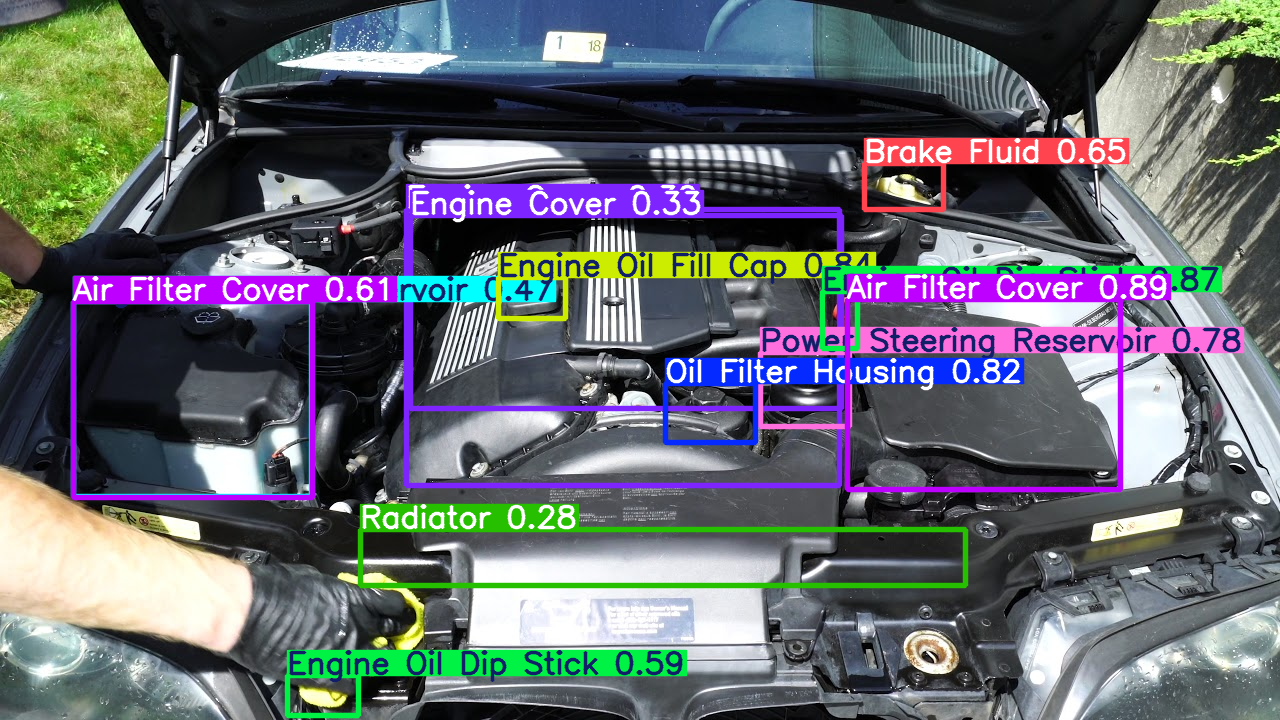

In [ ]:
from ultralytics import YOLO
from PIL import Image
import random
from IPython.display import display

# Use the ONNX that was just exported above
onnx_path = onnx_path  # already defined in the previous cell

try:
    # Load ONNX model
    onnx_model = YOLO(onnx_path)

    # Pick a random validation image
    val_image_dir = YOLO_IMAGES_PATH / 'val'
    random_image_path = random.choice(list(val_image_dir.glob('*.jpg')))
    print(f"Running inference on: {random_image_path.name}")

    # Inference
    results = onnx_model.predict(random_image_path)

    if results:
        res_plotted = results[0].plot()  # BGR numpy array
        img = Image.fromarray(res_plotted[..., ::-1])  # Convert BGR → RGB
        display(img)

except Exception as e:
    print(f"An error occurred during inference: {e}")

## 6. Save final model (PT + ONNX) to permanent MechAI folder

In [ ]:
import shutil
from pathlib import Path

# Path where you want your permanent model stored
OUT_DIR = Path("../models/yolo/yolov8s_enginebay_v1")
OUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Saving final model files to: {OUT_DIR}")

# Copy best.pt
best_pt = Path(best_model_path)
if best_pt.exists():
    shutil.copy(best_pt, OUT_DIR / "best.pt")
    print("✔ Saved best.pt")
else:
    print("⚠ best.pt not found!")

# Copy ONNX
best_onnx = Path(onnx_path)
if best_onnx.exists():
    shutil.copy(best_onnx, OUT_DIR / "best.onnx")
    print("✔ Saved best.onnx")
else:
    print("⚠ best.onnx not found!")

print("\n🎉 Final YOLO model saved safely.")